In [1]:
# Import Libraries
import mesa
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from scipy.optimize import curve_fit
import random

# Import Model
from model import Schelling

# PART 1: Analysis Techniques

## Find the wealth distribution of the USA:
We have found that the wealth distribution of the USA closly resembles a log normal distribution [SOURCE]. To test the initial wealth distribution of our agents we have created the function ```test_USA_wealthDist(num_agents, mean, std_dev)```. We used this function to find the appropriate parameters (mean/standard deviation) of the distribution.

In [ ]:
def plot_lognormal_dist(num_agents, mean, std_dev):
    """
    Test the distribution of initial wealth of agents
    We choose a lognormal distribution for the initial wealth of agents
    as it is a good approximation of the distribution of wealth in the USA
    """

    initial_wealth = []
    for i in range(num_agents):
        initial_wealth.append(np.random.lognormal(mean, std_dev))

    # Plotting the distribution
    plt.hist(initial_wealth, bins=30, color='#3f60af', edgecolor='black')
    plt.xlabel('Amount Wealth')
    plt.ylabel('Frequency')
    plt.title('Distribution of Initial Wealth')
    plt.show()

    return initial_wealth

def test_USAwealthDist(initial_wealth):
    """
    Tests the distribution of initial wealth of agents and plots the total wealth
    owned by each wealth class.
    
    Args:
        num_agents: Number of agents in the model
        mean: Mean of the logarithm of the distribution
        std_dev: Standard deviation of the logarithm of the distribution
    """

    # Calculate wealth thresholds for different wealth classes
    thresholds = np.percentile(initial_wealth, [99, 80, 60, 40, 20])

    # Categorize the wealth of each agent into different classes
    classes = np.zeros(len(initial_wealth))
    classes[initial_wealth >= thresholds[0]] = 5  # Top 1%
    classes[(initial_wealth >= thresholds[1]) & (initial_wealth < thresholds[0])] = 4  # Top 20% (excluding top 1%)
    classes[(initial_wealth >= thresholds[2]) & (initial_wealth < thresholds[1])] = 3  # Fourth 20%
    classes[(initial_wealth >= thresholds[3]) & (initial_wealth < thresholds[2])] = 2  # Middle class
    classes[(initial_wealth >= thresholds[4]) & (initial_wealth < thresholds[3])] = 1  # Second 20%
    classes[initial_wealth < thresholds[4]] = 0  # Bottom 20%

    # Calculate the total wealth owned by each wealth class
    wealth_by_class = [np.sum(np.array(initial_wealth)[classes == i]) for i in range(6)]
    
    # Plotting the total wealth owned by each wealth class
    class_labels = ['Bottom 20%', 'Second 20%', 'Middle class', 'Fourth 20%', 'Top 20%', 'Top 1%']
    
    plt.bar(class_labels, wealth_by_class, color='#dd4f5d', edgecolor='black')
    plt.xlabel('Wealth Class')
    plt.ylabel('Total Wealth')
    plt.title('Distribution of Initial Wealth by Wealth Class')

    plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels

    plt.tight_layout()  # Adjust spacing for better visibility of labels
    plt.show()

num_agents = 10000
mean = 1.0  # Mean of the logarithm of the distribution
std_dev = 1.5  # Standard deviation of the logarithm of the distribution
initial_wealth = plot_lognormal_dist(num_agents, mean, std_dev)
test_USAwealthDist(initial_wealth)
print(np.var(initial_wealth) / num_agents)

## Spatial visualization of the wealth distribution:
We created a 2D heatmap plot, to gain a better understanding of the spatial distribution of wealth over the entire system.
In this heatmap, the yellow cells represent the most wealthy agents, and the darker blue cells represent the poorest agents. If a cell has a wealth of 0, you are right to assume that the cell is empty, as an agent's wealth can never be 0. The function ```plot2D_modelWealth()``` plots the spatial wealth distribution, while the function ```plot2D_modelTypes()``` simply plots the spatial distribution of agent types (regular Schelling model).

In [ ]:
def plot2D_modelWealth(model):
    """
    Plots a 2D density heatmap of the model.
        x-axis: x position
        y-axis: y position
        weights: wealth
    """

    # Extract data from model
    x_coords = np.array([agent.pos[0] for agent in model.schedule.agents])  # Agent x coords
    y_coords = np.array([agent.pos[1] for agent in model.schedule.agents])  # Agent y coords
    wealths = np.array([agent.wealth for agent in model.schedule.agents])   # Agent wealths 
    df = pd.DataFrame({'x_pos': x_coords, 'y_pos': y_coords, 'wealth': wealths})

    # Create the 2D density heatmap
    fig = px.density_heatmap(df, x='x_pos', y='y_pos', z='wealth', nbinsx=model.size, nbinsy=model.size)

    # Set axis labels
    fig.update_layout(
        height=720, width=720,
        xaxis_title='X pos', yaxis_title='Y pos', 
        coloraxis_colorbar_title='Wealth',
        title=f'Spatial wealth distribution (t={model.schedule.steps})'
    )

    # Show the plot
    fig.show()

def plot2D_modelTypes(model):
    """
    Plots the model as a 2D scatterplot.
        x-axis: x position
        y-axis: y position
        color: agent type
    """

    # Extract data from model
    positions = [agent.pos for agent in model.schedule.agents]
    types = [agent.type for agent in model.schedule.agents]

    # Create the 2D scatterplot
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 9)

    # Define agent colors
    agent_colors = {
        0: {'color': '#FF0000', 'label': 'Agent Type 0'},
        1: {'color': '#00FF00', 'label': 'Agent Type 1'},
        2: {'color': '#0000FF', 'label': 'Agent Type 2'},
        3: {'color': '#FFA500', 'label': 'Agent Type 3'},
        4: {'color': '#FF00FF', 'label': 'Agent Type 4'},
        5: {'color': '#00FFFF', 'label': 'Agent Type 5'},
        6: {'color': '#FFFF00', 'label': 'Agent Type 6'},
        7: {'color': '#800080', 'label': 'Agent Type 7'},
        8: {'color': '#008000', 'label': 'Agent Type 8'},
        9: {'color': '#FFC0CB', 'label': 'Agent Type 9'}
    }
    colors = [agent_colors[agent_type]['color'] for agent_type in types]

    ax.scatter(*zip(*positions), color=colors, s=10)
    ax.set_title(f'Schelling model (t={model.schedule.steps})', fontsize=10, fontweight='bold')
    ax.set_xlabel('X pos', fontsize=10)
    ax.set_ylabel('Y pos', fontsize=10)
    ax.set_xlim([0, model.size])
    ax.set_ylim([0, model.size])

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

## Wealth distribution over time:
To visualize the evolution of wealth distribution during the model simulation, we implemented the function ```wealth_dist_lineplot```. This function creates a simple line plot of the total wealth of each agent type for each time step of the simulation.  

In [ ]:
def wealth_dist_lineplot(model):
    """
    Creates a line plot of the wealth distribution over time.
    """

    # Extract data
    wealth_dist = model.datacollector.get_model_vars_dataframe()['wealth_dist']
    time = np.arange(len(wealth_dist))

    # Define agent colors
    agent_colors = {0: '#FF0000', 1: '#00FF00', 2: '#0000FF', 3: '#FFA500', 4: '#FF00FF', 5: '#00FFFF', 6: '#FFFF00', 7: '#800080', 8: "#008000", 9: "#FFC0CB"}
    colors = [agent_colors[agent_type] for agent_type in wealth_dist[0].keys()]

    # Creating the line plot
    for type in range(model.N):
        plt.plot(time, wealth_dist.apply(lambda x: x[type]), label=f'Agent-type {type}', color=colors[type])    

    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Wealth')
    plt.title('Wealth distribution over time')
    # Adding a legend
    plt.legend()
    # Displaying the chart
    plt.show()

## Wealth distribution for each agent type:

In [ ]:
def wealth_dist_histograms(model):
    """
    Creates wealth distribution histograms over time for each agent type.
    """

    # Extract data
    wealth_dist = model.datacollector.get_model_vars_dataframe()['wealth_dist']
    time = np.arange(len(wealth_dist))

    # Define agent colors
    agent_colors = {0: '#FF0000', 1: '#00FF00', 2: '#0000FF', 3: '#FFA500', 4: '#FF00FF', 5: '#00FFFF', 6: '#FFFF00', 7: '#800080', 8: "#008000", 9: "#FFC0CB"}
    colors = [agent_colors[agent_type] for agent_type in wealth_dist[0].keys()]

    # Creating wealth distribution histograms
    for agent_type in wealth_dist[0].keys():
        wealth_data = [wealth_dist[i][agent_type] for i in range(len(wealth_dist))]
        plt.hist(wealth_data, bins='auto', alpha=0.4, label=f'Agent-type {agent_type}', color=colors[agent_type])

    # Adding labels and title
    plt.xlabel('Wealth')
    plt.ylabel('Frequency')
    plt.title(f'Wealth Distribution Histograms (t={model.schedule.steps})')
    # Adding a legend
    plt.legend()
    # Displaying the histograms
    plt.show()

## Segregation coefficient
To measure the amount of segregation we use the segregation coefficient based on the article by Gauvin et al. (2009). We implemented the ```WeightedAverage``` to find the normalized weighted average of the cluster sizes. To find the segregation coefficient we need to average the normalized weighted average over multiple model runs.

In [ ]:
def WeightedAverage(model):
    """
    Calculates the weighted average of cluster size. Works for multiple populations with different weights.
    """
    s = 0
    
    for i in model.cluster_sizes:
        a = 0
        
        # Squaring the cluster sizes and summing them per population
        for j in range(len(model.cluster_sizes[i])):
            a += model.cluster_sizes[i][j]**2
        
        # Finding the normalized weighted average for population i and adding them up to the others
        s += (1/(model.grid.width*model.grid.height*model.pop_weights[i])**2)*a
    
    return s/model.N

## Wealth segregation
We want to be able to determine clustering based on the wealth levels. To do this we first define ```WealthOnGrid``` to put the wealth of each agent at the end of the model run on an numpy array. This function also plots the wealths on the grid in a heatmap.

In [ ]:
def WealthOnGrid(model, plot=True):
    """
    Function that takes the model as input and finds the wealth of the agents at different points in the grid and puts that 
    into a numpy array. The wealth is then also plotted in a heatmap and returns the array with the wealths.
    """
    wealth_on_grid = np.zeros((model.grid.width, model.grid.height))

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        if cell_content:
            wealth_on_grid[x][y] = cell_content.wealth

    if plot:
        plt.imshow(wealth_on_grid, interpolation="nearest")
        plt.colorbar()
        plt.show()
    
    return wealth_on_grid

To look at wealth clusters we use variance. We start with a (random) starting position on the grid and calculate the variance (for the first iteration this will thus be 0), then we build a 2x2 square on that position and again calculate the variance. This square will be increased step by step until it is the size of the entire grid. The variance is then plotted against the size of the side of the square. This is done by the function ```WealthSegregation```, the function returns the list with variances.

In [ ]:
def WealthSegregation(model, x, y, plot=True):
    """
    Function that takes as input the model, the array with wealths per grid location and an x and y integer. This function 
    calculates the variance of a growing square in the grid, with starting location (x,y). It returns an array with the variance
    per square side size.
    """
    # Initial values
    wealth_on_grid = WealthOnGrid(model, False)
    N = model.grid.width
    var_list = []
    L_list = []

    for L in range(1, N):
        
        # Determine the coordinates of the square based on the initial coordinate and L
        start_row = x - (L // 2)
        end_row = start_row + L
        start_col = y - (L // 2)
        end_col = start_col + L

        # Adjust the coordinates if they exceed the array boundaries
        if end_row > N:
            start_row -= end_row - N
            end_row = N
        if end_col > N:
            start_col -= end_col - N
            end_col = N
        if start_row < 0:
            end_row -= start_row
            start_row = 0
        if start_col < 0:
            end_col -= start_col
            start_col = 0

        # Calculate the variance of wealth in the square
        var = np.var(wealth_on_grid[start_row:end_row, start_col:end_col])

        # Append variance to list
        var_list.append(var)
        L_list.append(L)
        
    # Delete the first element of both lists (zero variance for square of 1x1)
    var_list.pop(0)
    L_list.pop(0)    

    if plot:
        plt.plot(L_list, var_list)
        plt.xlabel("L")
        plt.ylabel("variance")
        plt.show()
    
    return var_list

In the above function the result is very dependent on the starting position that is taken. In the following function ```WealthSegregationAverage``` we take the average for all starting positions.

In [ ]:
def WealthSegregationAverage(model):
    """
    Fuction that finds the average variance for different square sizes L over all possible starting coordinates (x,y).
    """
    var = np.zeros(model.grid.width-2)
    
    # Fiding the variances for all starting coordinates and summing them together
    for x in range(0, model.grid.width):
        for y in range(0, model.grid.height):
            var_list = WealthSegregation(model, x, y, False)
            var += var_list
    
    # Calculating the average
    average_vars = var/model.grid.width
    L = np.array(range(1, model.grid.width-1))
    
    plt.plot(L, average_vars)
    plt.title("Average variance for different square sizes L")
    plt.xlabel("L")
    plt.ylabel("Variance")
    plt.show()
    
    return average_vars

We want to look at the derivative of the average variance, so we introduce a function to calculate the derivative of two arrays:

In [ ]:
def derivative(x,y):
    derivative = np.zeros((len(x), len(y)))
    for i in range(len(x)-1):
        derivative[i] = (y[i] - y[i+1]) / (x[i] - x[i+1])
    return derivative

We wanted to check whether the output was an logarithmic function and then, if so, what the value of the ase is. To do this we need to define an exponential function, ```LogarithmicFunc```.

In [ ]:
def LogarithmicFunc(x, a, b):
    return a * np.log(x) + b

## @Jonathan, kan jij hier uitleg bij geven?

In [ ]:
def plot_clusterSizesDistribution(model):
    """
    Function that plots the distribution of cluster sizes.
    """
    for value in model.cluster_sizes.keys():
        plt.hist(model.cluster_sizes[value],bins=100, density=True)
        plt.show()

# PART 2: Experiments
### - Experiment 1: Highly segregated / Large custers (example):

In [ ]:
# Define model parameters
size = 100
density = 0.9
fixed_areas_pc = 0.0
popilation_sizes = [0.6, 0.2, 0.2]
homophily = 5
cluster_threshold = 4
alpha=0.4
stopping_threshold=500
server=False

# Create the model
model = Schelling(size, density, fixed_areas_pc, popilation_sizes, homophily, cluster_threshold, alpha, stopping_threshold, server)

# Plot starting type/wealth distribution
plot2D_modelTypes(model)
plot2D_modelWealth(model)

# Run the model
steps = 200
for i in range(steps):
    model.step()


In [ ]:
# Plot ending type/wealth distribution
plot2D_modelTypes(model)
plot2D_modelWealth(model)

In [ ]:
import itertools


# for value in model.cluster_sizes.keys():
#     plt.hist(model.cluster_sizes[value],bins=100, density=True)
#     plt.show()

segg_cluster = list(itertools.chain.from_iterable(model.cluster_sizes.values()))
plt.hist(segg_cluster,bins=20, density=False)
plt.xlabel("Cluster size")
plt.ylabel("Frequency")
plt.show()

# Extract data from model
x_coords = np.array([agent.pos[0] for agent in model.schedule.agents])  # Agent x coords
y_coords = np.array([agent.pos[1] for agent in model.schedule.agents])  # Agent y coords
wealths = np.array([agent.wealth for agent in model.schedule.agents])   # Agent wealths 
array = pd.DataFrame({'x_pos': x_coords, 'y_pos': y_coords, 'wealth': wealths}).to_numpy()

cluster_sizes = model.find_cluster_sizes(array)
# for value in cluster_sizes.keys():
#     clusters = 
#     plt.hist(model.cluster_sizes[value],bins=100, density=True)
#     plt.show()

wealth_cluster = list(itertools.chain.from_iterable(cluster_sizes.values()))
plt.hist(wealth_cluster,bins=20, density=False)
plt.xlabel("Cluster size")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Plot wealth distribution over time
wealth_dist_lineplot(model)
wealth_dist_histograms(model)


### - Experiment 2: Finding the Segregation Coefficient:


In [ ]:
# We find the segregation coefficient by averaging the normalized weighted average cluster size

# Define model parameters
size = 100
density = 0.9
fixed_areas_pc = 0.0
popilation_sizes = [0.6, 0.4]
homophily = 6
cluster_threshold = 4
alpha=0.01
stopping_threshold=5
server=False

# Initial value
a = 0

for i in range(10):
    # Create the model
    model = Schelling(size, density, fixed_areas_pc, popilation_sizes, homophily, cluster_threshold, alpha, stopping_threshold, server)
    
    while model.running and model.schedule.steps < 100:
        model.step()
    a += WeightedAverage(model)

SegCoef = a/10
print("Segregation Coefficient:", SegCoef)

### - Experiment 3: Wealth Segregation:

In [ ]:
# Define model parameters
size = 100
density = 0.9
fixed_areas_pc = 0.0
popilation_sizes = [0.6, 0.4]
homophily = 6
cluster_threshold = 4
alpha=0.5
stopping_threshold=5
server=False

# Getting the variance plot for a random initial coordinate
x = random.randint(0, model.grid.width-1)
y = random.randint(0, model.grid.width-1)

var = WealthSegregation(model, x, y, True)

# Getting the average variance over all possible starting coordinates
average_var = WealthSegregationAverage(model)

In [ ]:
# Calculate half-time of average variance plot
end_value = average_var[len(average_var)-1]
half_time = np.interp(0.5*end_value, average_var, L)
print(half_time)

In [ ]:
# Calculate the derivative of the avergae variance plot
deriv = derivative(L, average_var)
plt.plot(L, deriv, '-b')
plt.show()

In [ ]:
# Fitting logaritmic fucntion
params, _ = curve_fit(LogarithmicFunc, L, average_var)

a_fit, b_fit = params

# Plot the original data and fitted curve
plt.scatter(L, average_var, label='Original data')
plt.plot(L, LogarithmicFunc(L, a_fit, b_fit), 'r-', label='Fitted curve')
plt.legend()
plt.xlabel('L')
plt.ylabel('Average variance')
plt.show()

In [ ]:
# Calculating the half-time of the logarithm
end_value = LogarithmicFunc(1000, a_fit, b_fit)
half_time = np.interp(0.5*end_value, LogarithmicFunc(L, a_fit, b_fit), L)

print(half_time)

### - Experiment 4: Line plot density-segregation coefficient (plot 4)

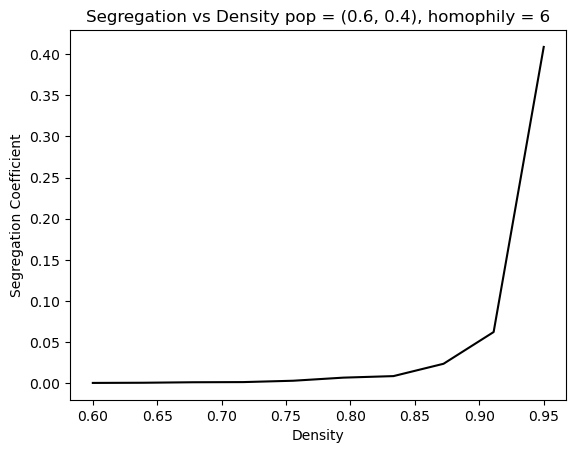

In [3]:
density_values = np.linspace(0.6,0.95, num=10)
segregation_list = []
for density in density_values:
    model = Schelling(size=100, density=density, fixed_areas_pc=0.0, pop_weights=(0.6,0.4), homophily=6, cluster_threshold=4, alpha=5, stopping_threshold=5)
    while model.running and model.schedule.steps < 100:
        model.step()
    segregation = model.cluster_coefficient
    segregation_list.append(segregation)

plt.plot(density_values, segregation_list, 'k-')
plt.title('Segregation vs Density pop = (0.6, 0.4), homophily = 6')
plt.xlabel('Density')
plt.ylabel('Segregation Coefficient')
plt.show()